# Predict Ranking of Teams in a Season

In [1]:
import pandas as pd
from scipy.stats import kendalltau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math

%matplotlib inline

## Data Overview
This section contains reading and exploration of data

In [2]:
player_df = pd.read_excel('train_data.xlsx',sheet_name='Player')
point_df = pd.read_excel('train_data.xlsx',sheet_name='Points')
print("Columns of player dataframe:")
print(player_df.columns)
print("Columns of points dataframe:")
print(point_df.columns)

Columns of player dataframe:
Index(['Season', 'Club', 'Player', 'Age', 'Foreign', 'Nationality',
       'Multinational', 'Market Value'],
      dtype='object')
Columns of points dataframe:
Index(['Season', 'Club', 'Points'], dtype='object')


In [3]:
described_columns = ['Age', 'Market Value']
for column in described_columns:
    print(player_df[column].describe())

count    4778.000000
mean       25.520301
std         4.093131
min        14.000000
25%        23.000000
50%        26.000000
75%        28.000000
max        38.000000
Name: Age, dtype: float64
count    4.778000e+03
mean     1.721085e+06
std      2.231122e+06
min      2.500000e+04
25%      4.500000e+05
50%      1.000000e+06
75%      2.000000e+06
max      3.200000e+07
Name: Market Value, dtype: float64


In [4]:
unique_clubs = player_df['Club'].unique()
len(unique_clubs), str(unique_clubs)

(31,
 "['Ankaragücü' 'Ankaraspor' 'Besiktas' 'Bursaspor' 'Büyüksehir Bld.'\n 'Denizlispor' 'Fenerbahce' 'Galatasaray' 'Gaziantepspor' 'GB Oftasspor'\n 'Genclerbirligi' 'Kasimpasa' 'Kayserispor' 'Konyaspor' 'Manisaspor'\n 'Rizespor' 'Sivasspor' 'Trabzonspor' 'Antalyaspor' 'Eskisehirspor'\n 'Kocaelispor' 'Diyarbakirspor' 'Bucaspor' 'Karabükspor' 'Mersin IY'\n 'Orduspor' 'Samsunspor' 'Akhisarspor' 'Elazigspor' 'K. Erciyesspor'\n 'Balikesirspor']")

## Helpful functions

Since the data contains some features which have similar properties. We thought writing generic functions could be helpful. 

### Getting Features

In [5]:
# Gets the mean of the specified column
def get_mean_of_column(df, column_name):
    return df.groupby(['Season','Club']).mean()[[column_name]]
# Gets the logarithm of the mean of the specified column
def get_log_of_mean(df, column_name):
    df = get_mean_of_column(df, column_name)
    #print(df[column_name].apply(np.log).to_frame())
    return df[column_name].apply(np.log).to_frame()
# Gets the exponential of the specified column
def get_exp_of_mean(df, column_name):
    df = get_mean_of_column(df, column_name)
    df[column_name] = (df[column_name]/100000)
    return df[column_name].apply(np.exp).to_frame()
# Gets the sum of the specified column
def get_sum_of_column(df, column_name):
    return df.groupby(['Season','Club']).sum()[[column_name]]
# Gets the min of the specified column
def get_min_of_column(df, column_name):
    return df.sort_values([column_name]).groupby(['Season','Club']).first()[[column_name]]
# Gets the mean of biggest K values in the specifies column
def get_topK_values_of_column(df, topK, column_name):
    df.sort_values(['Season', 'Club', column_name], ascending = [True, True, False], inplace = True) 
    df = df.groupby(['Season', 'Club'])[column_name].nlargest(topK).to_frame()
    df.reset_index(inplace=True)
    df = df.groupby(['Season', 'Club']).mean()[[column_name]]
    return df
# Gets the product of data frames 
def get_prod_of_two_column_means(first_df, second_df):
    first_df = first_df.join(second_df, how = 'inner')
    first_df[list(first_df)[0]+'Times'+list(first_df)[1]] = first_df[list(first_df)[0]]*second_df[list(first_df)[1]]
    first_df.drop([list(first_df)[0], list(first_df)[1]], axis=1, inplace=True)
    return first_df
# Gets the mean of columns of given dataframe
def get_mean_of_columns(df, column_namelist):
    return df.groupby(['Season','Club']).mean()[column_namelist]
# Merges the given data frames
def merge_features(df_list):
    new_df = df_list[0]
    for df in df_list[1:]:
        new_df = new_df.join(df, how = 'outer')
    return new_df

### Plots

We have also implemented some generic functions for plotting features 

In [6]:
# Generates the plot of the mean of the given columns 
def generate_mean_plot(df_feature,df_label,x_column,y_column):
    df_feature.set_index(['Season','Club'],inplace=True)
    df_label.set_index(['Season','Club'],inplace=True)
    df_feature=merge_features([df_feature,df_label])
    df_feature.reset_index(inplace=True)
    df_feature=df_feature.groupby(['Club']).mean()[[x_column, y_column]]
    plt.figure();
    df_feature.plot.scatter(x=x_column,y=y_column);
    plt.title("Average "+x_column+" and "+y_column+" of Seasons for All Clubs")
# Generates the plot of the mean of given feature and given label
def generate_min_plot(df_feature,df_label,x_column,y_column):
    df=get_min_of_column(df_feature.copy(), x_column) 
    df_label.set_index(['Season','Club'],inplace=True)
    df=df.join(df_label,how='inner')
    df.reset_index(inplace=True)
    df=df.groupby(['Club']).mean()[[x_column, y_column]]
    plt.figure();
    df.plot.scatter(x=x_column,y=y_column);
    plt.title("Average Minimum "+x_column+" and "+y_column+" of Seasons for All Clubs")
def generate_sum_plot(df_feature, df_label, x_column, y_column):
    df_feature.set_index(['Season','Club'],inplace=True)
    df_label.set_index(['Season','Club'],inplace=True)
    df_feature=merge_features([df_feature,df_label])
    df_feature.reset_index(inplace=True)
    df_feature=df_feature.groupby(['Club']).sum()[[x_column, y_column]]
    plt.figure();
    df_feature.plot.scatter(x=x_column,y=y_column);
    plt.title("Sum of "+x_column+" and "+y_column+" of Seasons for All Clubs")
    
def generate_prod_plot(df_feature,df_label,product_column1,product_column2,y_column):
    df = get_prod_of_two_column_means(get_mean_of_column(df_feature.copy(), product_column1), get_mean_of_column(df_feature.copy(), product_column2))
    df_label.set_index(['Season','Club'],inplace=True)
    df=df.join(df_label,how='inner')
    df.reset_index(inplace=True)
    prod=product_column1+'Times'+product_column2
    df=df.groupby(['Club']).mean()[[prod, y_column]]
    plt.figure();
    df.plot.scatter(x=prod,y=y_column);
    plt.title("Average  "+product_column1+"Times"+product_column2+" and "+y_column+" of Seasons for All Clubs")

## Feature Exploration

Now we have familiarized the data we will work on a little bit. Let's explore the relationship between the features of clubs and the points they got.

### Market Values

We know the unique clubs now. Let's look at the market values of players of the clubs. To get an idea about how the market value is related to the points a club takes. We have plotted the points with the sum and mean of market value of players of each season of the clubs. Since those which are in the league give more information about this relationship, we have plotted the teams which attended the league at least 8 seasons.  

C:\Users\rizao\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


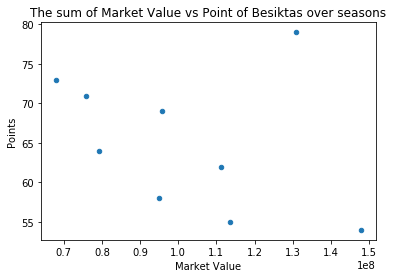

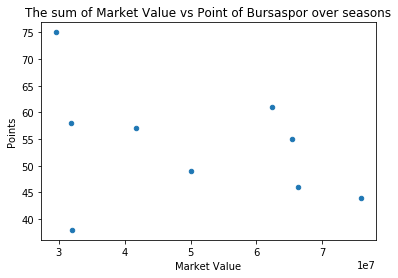

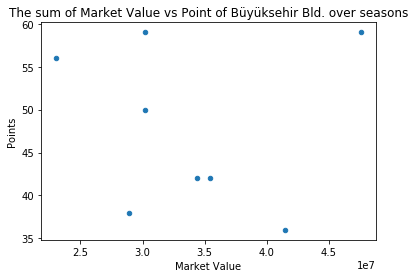

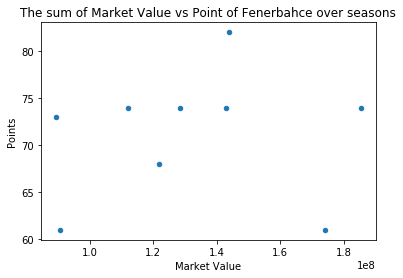

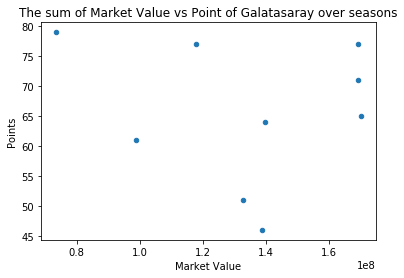

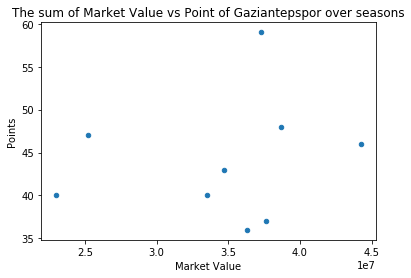

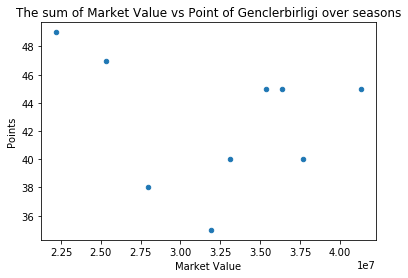

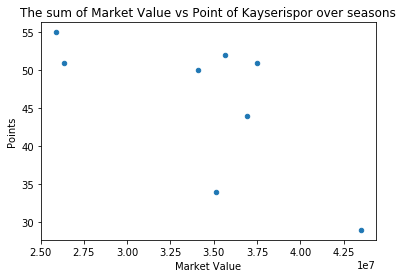

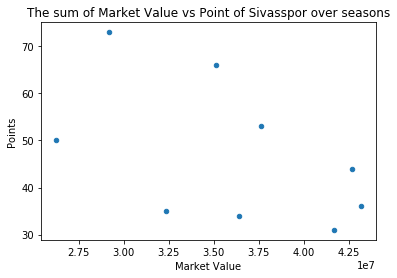

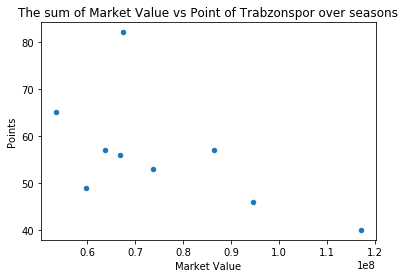

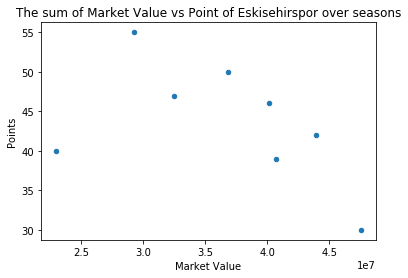

In [7]:
for club in unique_clubs:
    market_sum_df = player_df[player_df['Club'] == club].groupby(['Season']).sum()[['Market Value']]
    club_point_df = point_df[point_df['Club'] == club].set_index('Season')['Points']
    number_of_season_club_attended = club_point_df.shape[0]
    if number_of_season_club_attended >= 8:
        merged_df = market_sum_df.join(club_point_df, how = 'inner')
        plt.figure()
        merged_df.plot.scatter(x ="Market Value", y="Points")
        plt.title("The sum of Market Value vs Point of "+ club + " over seasons")

By looking the results we get, we can conclude that there is a little relationship between the sum of market value of its players and the points of a club. Let's take a look at the relation between the mean of market value and the points of the clubs.

C:\Users\rizao\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


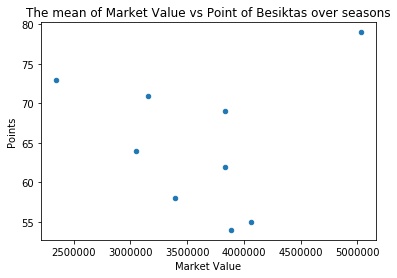

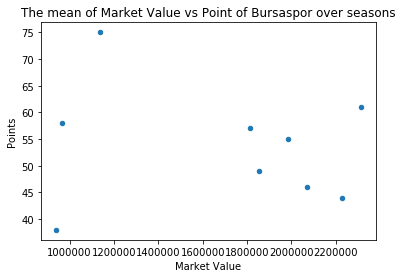

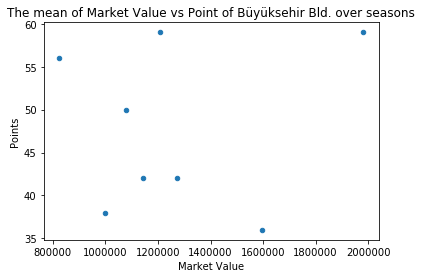

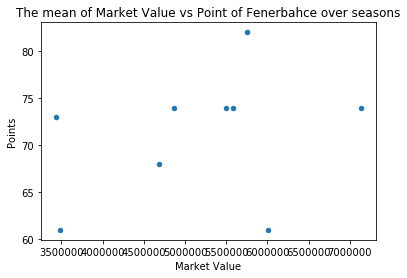

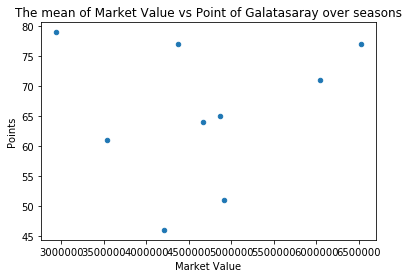

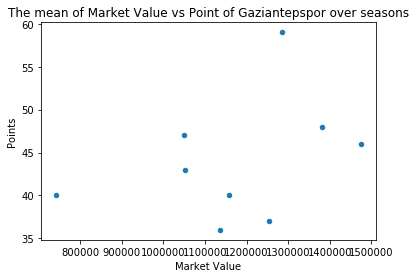

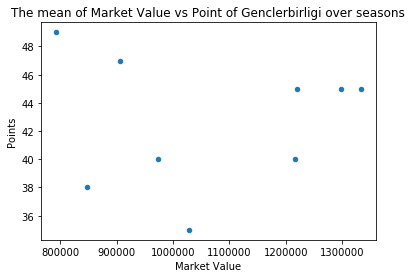

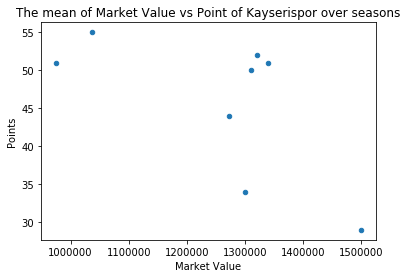

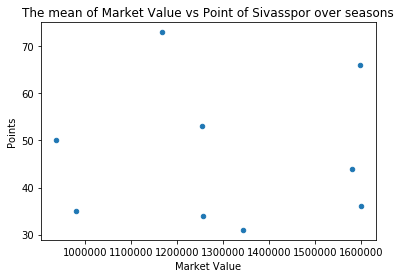

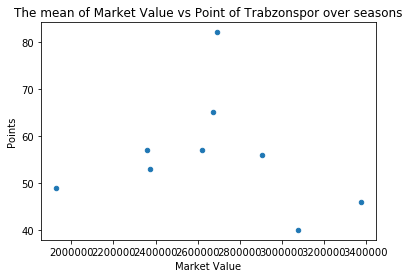

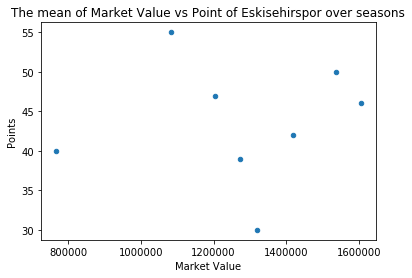

In [8]:
for club in unique_clubs:
    market_sum_df = player_df[player_df['Club'] == club].groupby(['Season']).mean()[['Market Value']]
    club_point_df = point_df[point_df['Club'] == club].set_index('Season')['Points']
    number_of_season_club_attended = club_point_df.shape[0]
    if number_of_season_club_attended >= 8:
        merged_df = market_sum_df.join(club_point_df, how = 'inner')
        plt.figure()
        merged_df.plot.scatter(x ="Market Value", y="Points")
        plt.title("The mean of Market Value vs Point of "+ club + " over seasons")

Although the mean of market values and the point of club looks like distributed randomly, in general we see that there is an almost strong relationship between the mean of market values and the point of a club. Now we'll look at the minimum of market values of clubs vs points. 

C:\Users\rizao\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


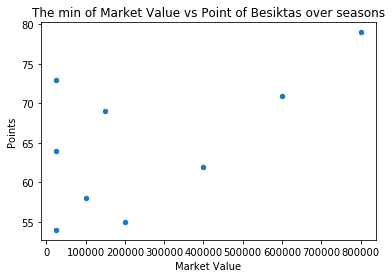

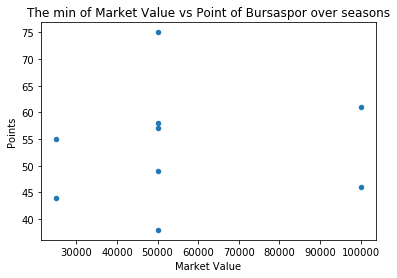

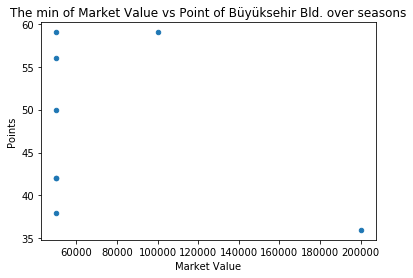

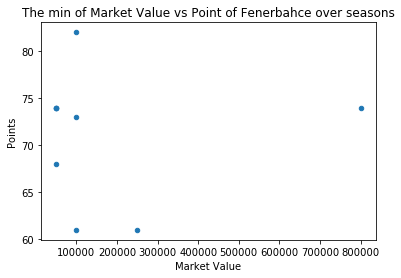

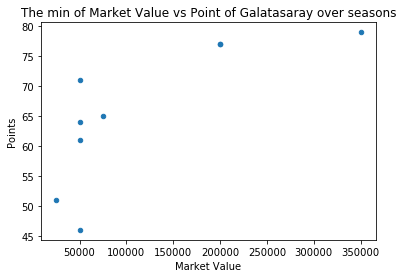

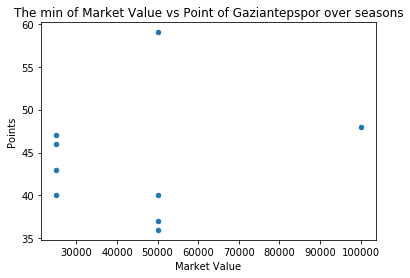

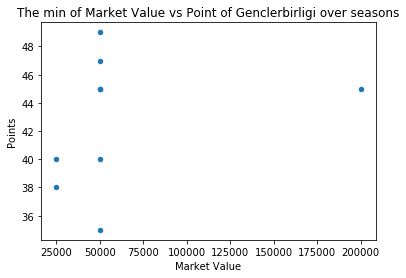

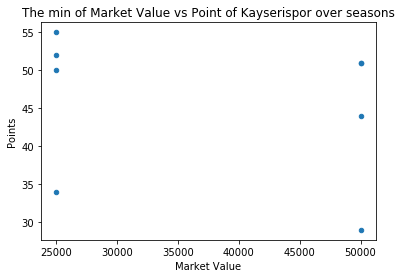

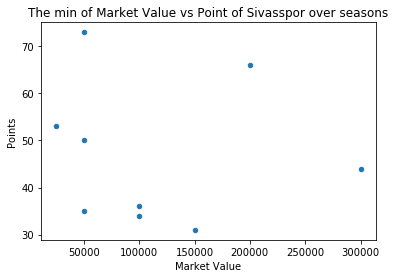

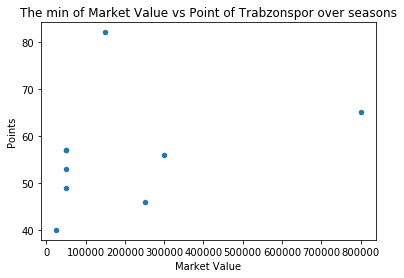

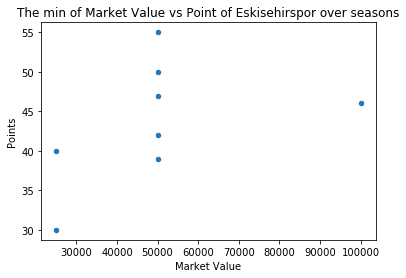

In [9]:
for club in unique_clubs:
    market_sum_df = player_df[player_df['Club'] == club].groupby(['Season']).min()[['Market Value']]
    club_point_df = point_df[point_df['Club'] == club].set_index('Season')['Points']
    number_of_season_club_attended = club_point_df.shape[0]
    if number_of_season_club_attended >= 8:
        merged_df = market_sum_df.join(club_point_df, how = 'inner')
        plt.figure()
        merged_df.plot.scatter(x ="Market Value", y="Points")
        plt.title("The min of Market Value vs Point of "+ club + " over seasons")

From these plots, we cannot conclude a general conclusion about the effect of minimum of market value on points. However, we can see that for the clubs that have higher points like Besiktas and Galatasaray in general there is a correlation between the min of market values and the points.

To see the overall relation between these features of market values of clubs and points, we have plotted the relations overall seasons.

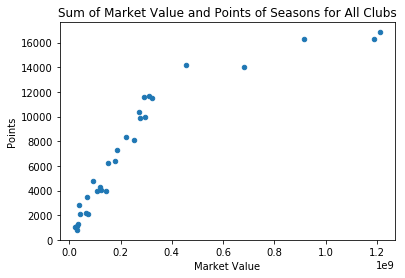

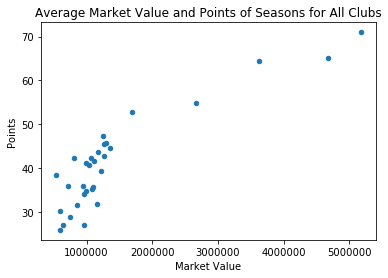

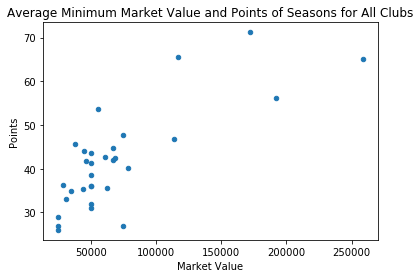

In [10]:
generate_sum_plot(player_df.copy(), point_df.copy(), 'Market Value','Points')
generate_mean_plot(player_df.copy(), point_df.copy(),'Market Value','Points')
generate_min_plot(player_df.copy(), point_df.copy(),'Market Value','Points')

Although we couldn't see a relation between some of features of market values for individual clubs, by lookinga at the plots of overall seasons we can say that there is a somewhat linear relation among features of market values and points. However, for some features like average min the relation is not strong as the other ones. 

### Foreign

Now we try to investigate the effect of foreign/national players of clubs on the points of the clubs. Firstly, we will look at the mean of the foreign column of dataframe which corresponds to the proportion of the foreign players of a club to all players of a club and then the sum of the foreign column which corresponds to the total foreign players of the club.

C:\Users\rizao\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


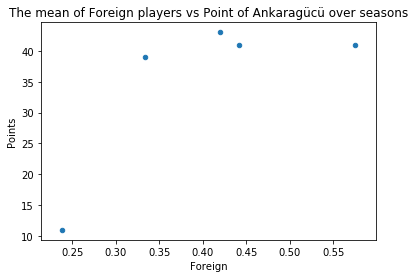

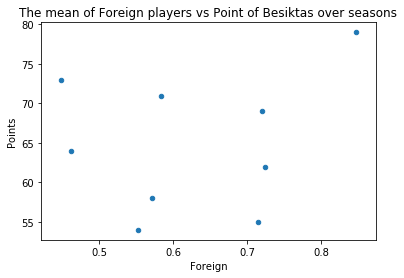

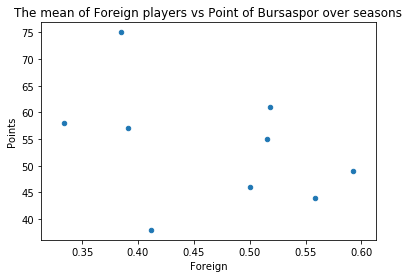

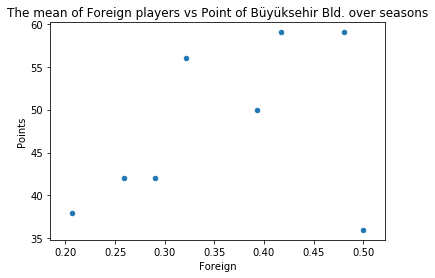

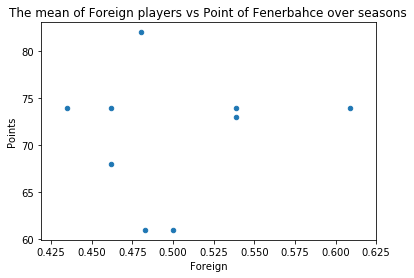

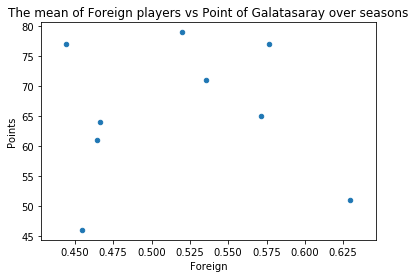

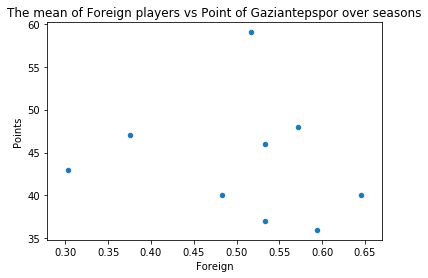

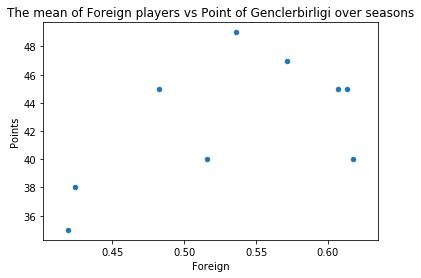

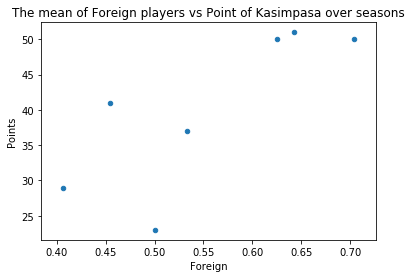

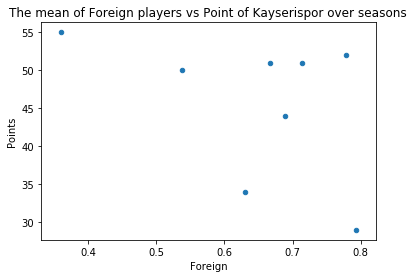

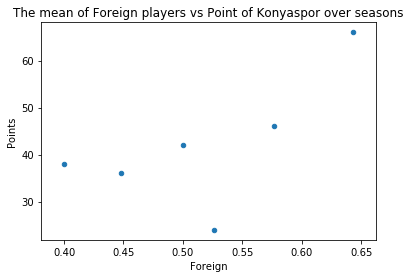

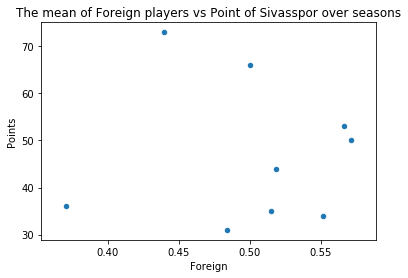

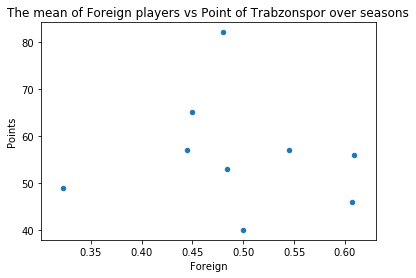

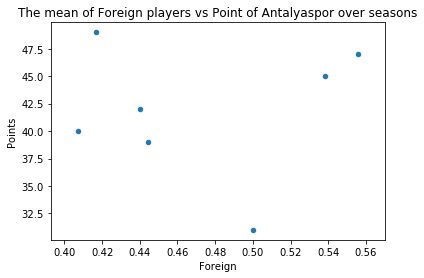

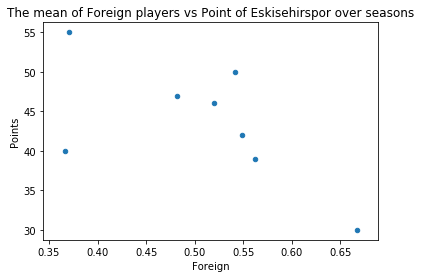

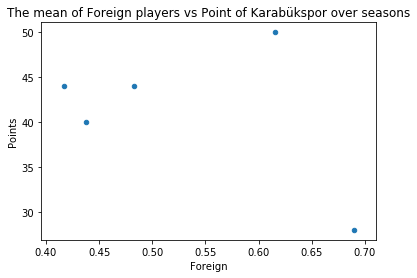

In [11]:
for club in unique_clubs:
    foreign_mean_df = player_df[player_df['Club'] == club].groupby(['Season']).mean()[['Foreign']]
    club_point_df = point_df[point_df['Club'] == club].set_index('Season')['Points']
    number_of_season_club_attended = club_point_df.shape[0]
    if number_of_season_club_attended >= 5:
        merged_df = foreign_mean_df.join(club_point_df, how = 'inner')
        plt.figure()
        merged_df.plot.scatter(x ="Foreign", y="Points")
        plt.title("The mean of Foreign players vs Point of "+ club + " over seasons")

By looking the plots for clubs, we can say that the relation among the mean of foreign players of a club and the points cannot be generalized for all clubs since there are exceptions but there is like a positive correlation between these features especially for clubs that have attended the league less. 

/media/gokce/Data/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


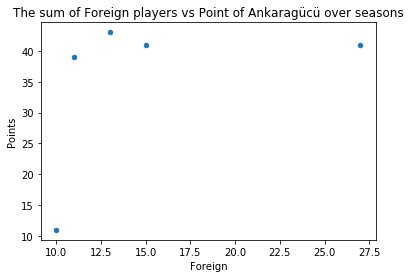

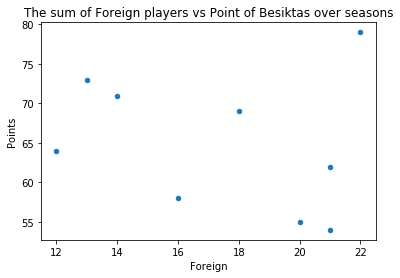

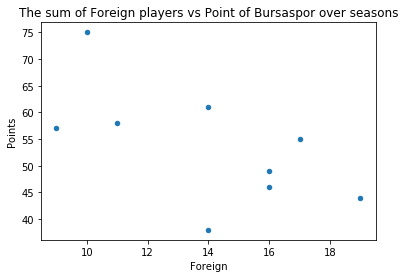

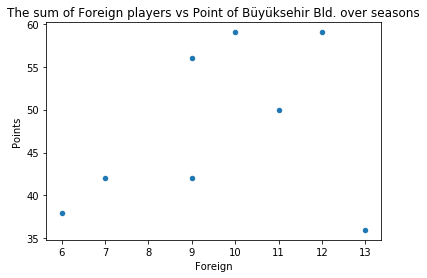

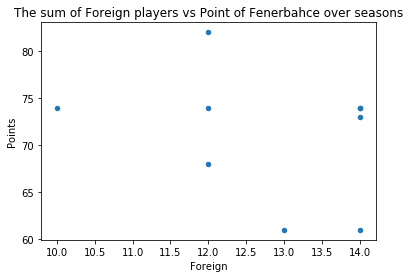

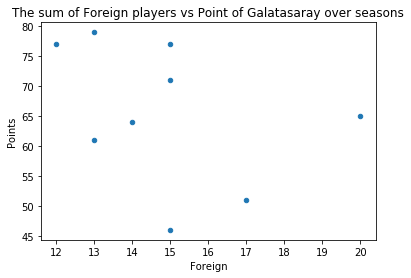

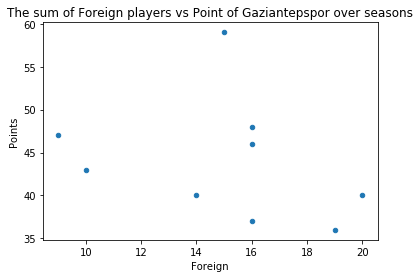

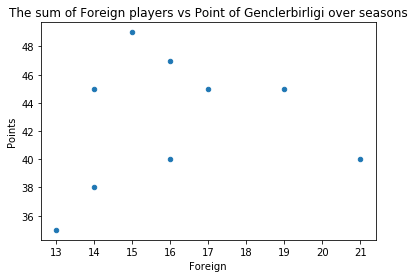

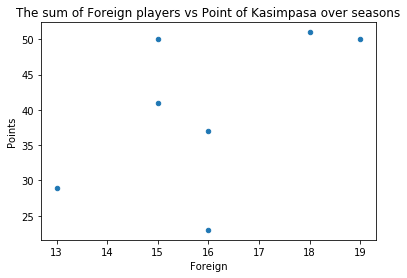

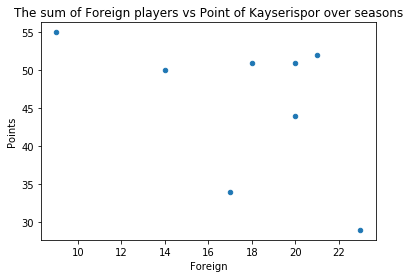

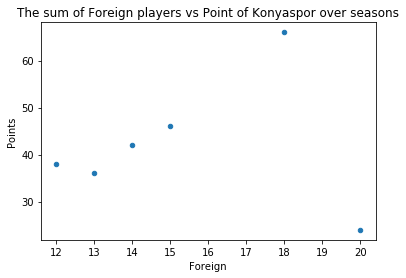

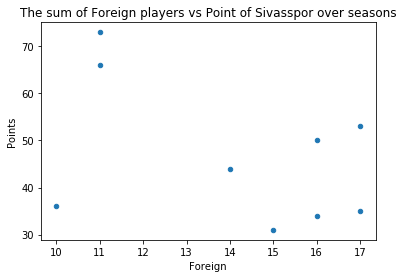

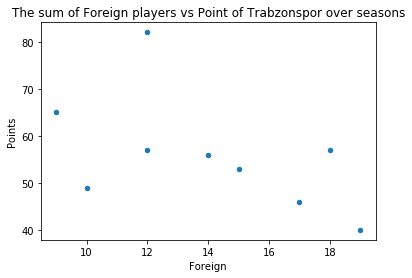

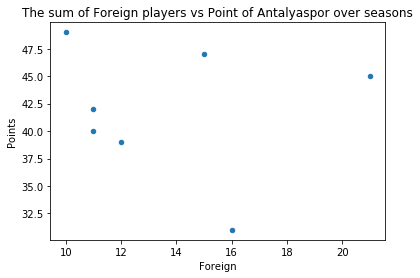

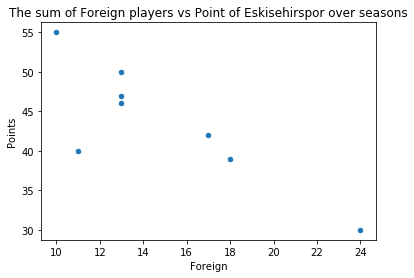

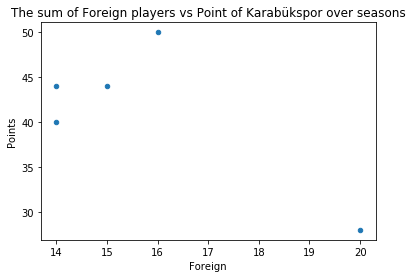

In [79]:
for club in unique_clubs:
    foreign_mean_df = player_df[player_df['Club'] == club].groupby(['Season']).sum()[['Foreign']]
    club_point_df = point_df[point_df['Club'] == club].set_index('Season')['Points']
    number_of_season_club_attended = club_point_df.shape[0]
    if number_of_season_club_attended >= 5:
        merged_df = foreign_mean_df.join(club_point_df, how = 'inner')
        plt.figure()
        merged_df.plot.scatter(x ="Foreign", y="Points")
        plt.title("The sum of Foreign players vs Point of "+ club + " over seasons")

From these plots, the conclusion we have derived is that the clubs that have got less points or have participated the league less are more likely to get higher points when the total number of foreign players of the club is increased.

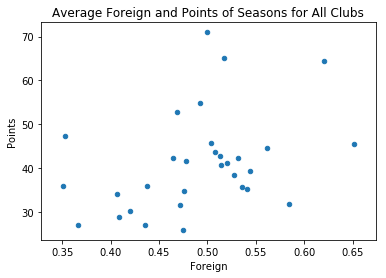

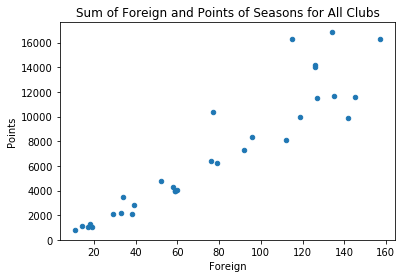

In [12]:
generate_mean_plot(player_df.copy(), point_df.copy(),'Foreign','Points')
generate_sum_plot(player_df.copy(), point_df.copy(),'Foreign','Points')

From the above figures, we can easily see that both of the average number of foreign players and the total number of foreign players have a positive relationship with the points. However, the effect of total number of foreign players seems more consistent. Also, we can conclude that as the number of total number of foreign players of the club increases, its effect on the points diverges. 

### Age

Let's look at the age of players of the clubs. We are interested in the relation between the mean of the age and the points of the clubs. We have plotted the points with the  mean of age of players of each season of the clubs. We consider the clubs which attend at least 8 seasons.

C:\Users\rizao\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


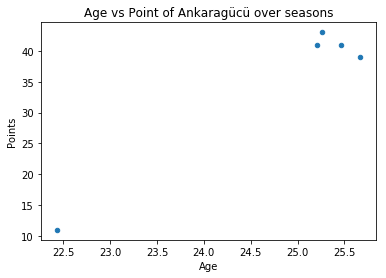

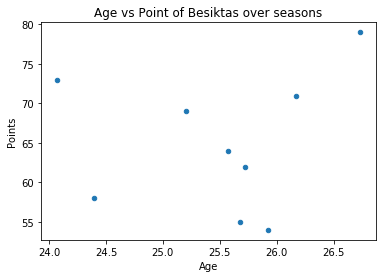

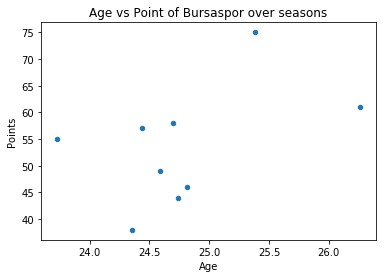

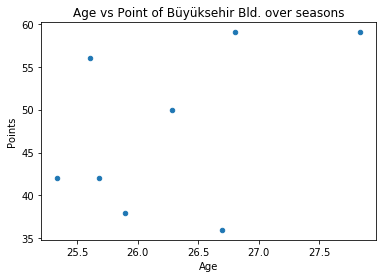

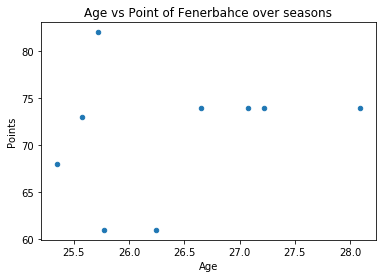

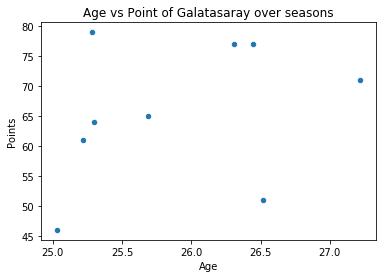

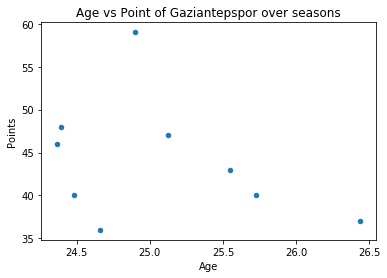

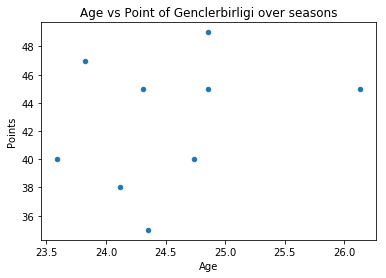

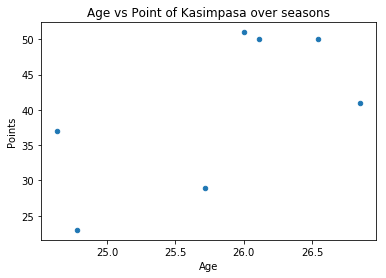

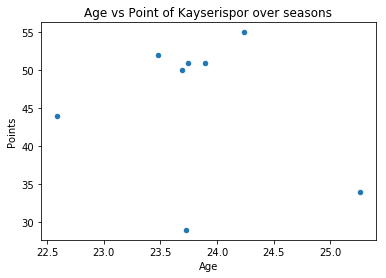

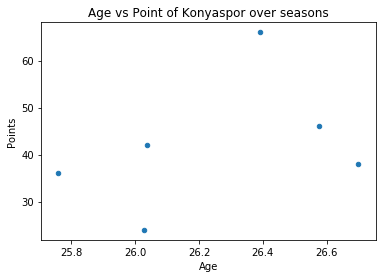

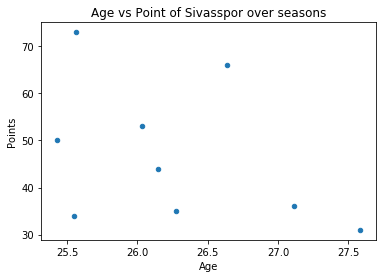

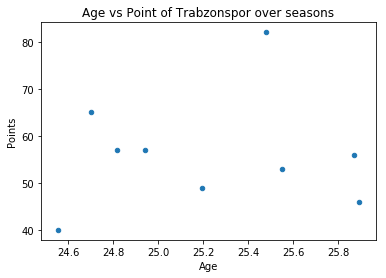

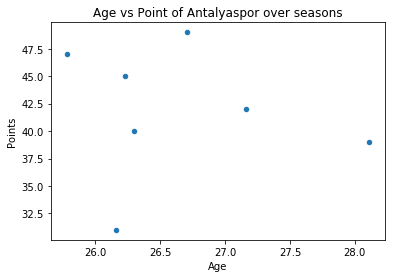

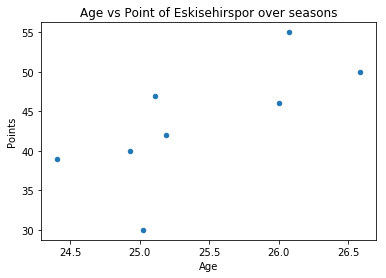

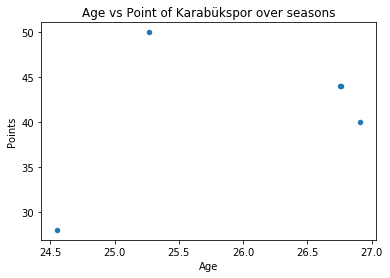

In [13]:
for club in unique_clubs:
    age_mean_df = player_df[player_df['Club'] == club].groupby(['Season']).mean()[['Age']]
    club_point_df = point_df[point_df['Club'] == club].set_index('Season')['Points']
    number_of_season_club_attended = club_point_df.shape[0]
    if number_of_season_club_attended >= 5:
        merged_df = age_mean_df.join(club_point_df, how = 'inner')
        plt.figure()
        merged_df.plot.scatter(x ="Age", y="Points")
        plt.title("Age vs Point of "+ club + " over seasons")

We realize that the relationship between the mean of age of the player in the club and the mean of the points of the club is not obvious. For some clubs the relation looks positively correlated, however for some others it looks opposite. Therefore, we look at the mean of the age and the mean of the points of clubs with all seasons.      

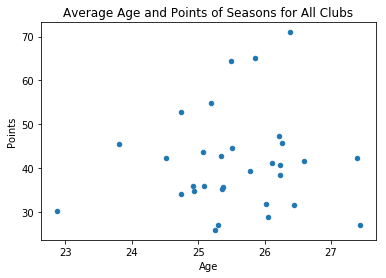

In [14]:
generate_mean_plot(player_df.copy(), point_df.copy(),'Age','Points')

From this figure, it seems there is a bit positive correlation between the mean of the age and the points in general. If we look at the clubs whose average points are higher than 50, we see that this relationship gets stronger. 

## Feature Selection

For the feature set 1, we chose four features that we found the most informative.
1. The first feature is the production of mean of the market values and mean of the ages. We thought that as the player gets older, his market value should decrease. However, if a player's market value is still high when he gets older, it shows the value of the player.
2. The second feature is minimum market value of clubs. If a club's minimum market value is still high, the probability of that club to be succesful increases.
3. The third and fourth values are mean of age and number of foreigns in club. The mean ages of the most successful clubs are close to the mean of total ages. It is the same for foreign feature.

In [15]:
def get_feature_set_1(df):
    df1 = get_prod_of_two_column_means(get_mean_of_column(df.copy(), 'Market Value'), get_mean_of_column(df.copy(), 'Age'))
    df2 = get_min_of_column(df.copy(), 'Market Value')
    df3 = get_mean_of_column(df.copy(), 'Age')
    df4 = get_mean_of_column(df.copy(), 'Foreign')
    df_list = [df1, df2, df3, df4]
    feature_set_1 = merge_features(df_list)
    return feature_set_1

For the feature set 2, we tried three features.
1. We chose exponential of means of market values, because the plot of mean market values looked like a log function to us. However, we saw that this feature did not change the correlation.
2. Age and foreign features are same as above.

In [16]:
def get_feature_set_2(df):
    df1 = get_exp_of_mean(df.copy(), 'Market Value')
    df2 = get_mean_of_column(df.copy(), 'Age')
    df3 = get_sum_of_column(df.copy(), 'Foreign')
    df_list = [df1, df2, df3]
    feature_set_2 = merge_features(df_list)
    return feature_set_2

For the feature set 3, we tried division of Market value and Age instead of production of them. This was the first idea that came into our minds. We thought that if a club has players who are expreienced but have great market values, that club gets more successful. Nevertheless, this feature did not give the effect we expect.

In [17]:
def get_feature_set_3(df):
    df1 = get_division_of_two_column_means(get_mean_of_column(df.copy(), 'Market Value'), get_mean_of_column(df.copy(), 'Age'))
    df2 = get_min_of_column(df.copy(), 'Market Value')
    df3 = get_mean_of_column(df.copy(), 'Age')
    df4 = get_mean_of_column(df.copy(), 'Foreign')
    df_list = [df1 ,df2 , df3 , df4]
    feature_set_3 = merge_features(df_list)
    return feature_set_3

By looking at the first feature of the feature set 1, we thought that the oldest 5 of clubs may give more information. However, it decreased the correlation.

In [18]:
def get_feature_set_4(df):
    df1 = get_prod_of_two_column_means(get_topK_values_of_column(df.copy(), 5, 'Age'), get_mean_of_column(df.copy(), 'Market Value'))
    df2 = get_min_of_column(df.copy(), 'Market Value')
    df3 = get_mean_of_column(df.copy(), 'Age')
    df4 = get_mean_of_column(df.copy(), 'Foreign')
    df_list = [df1 ,df2 , df3 , df4]
    
    df_list = [df1 ,df2,df3, df4 ]
    feature_set_4 = merge_features(df_list)
    return feature_set_4

## Constructing Features

We have chosen the first feature set and constructed our features correspondingly. Since the training set contains NA values, we have used different functions for constructing training and test sets. Also we have used different constructing label functions to return points in training and rankings in test.  

In [19]:
# Takes inner join and handles the NA values
def construct_features_for_training(player_df, point_df):
    player_df = get_feature_set_1(player_df)   
    point_df.set_index(['Season','Club'], inplace = True) 
    player_df = player_df.join(point_df,how='inner')
    player_df.drop(['Points'],axis = 1, inplace = True)    
    player_df = player_df.reset_index()  
    player_df.sort_values(['Season', 'Club'], ascending = [True, True], inplace = True)  
    player_df.set_index(['Season','Club'], inplace = True)       
    return player_df

In [20]:
def construct_labels_for_training(df): 
    df = df.reset_index()
    df.sort_values(['Season', 'Club'], ascending = [True, True], inplace = True)
    df.set_index(['Season','Club'], inplace = True)        
    return df['Points']

In [21]:
def construct_features(df):
    df = get_feature_set_1(df)
    df = df.reset_index()
    df.sort_values(['Season', 'Club'], ascending = [True, True], inplace = True)  
    df.set_index(['Season','Club'], inplace = True)           
    return df

In [22]:
def construct_labels(df):
    df.sort_values(['Season', 'Points'], ascending = [True, False], inplace = True)
    df['Rank'] = df.groupby('Season')['Points'].rank(method = 'first', ascending = 0)    
    df = df.reset_index()
    df.sort_values(['Season', 'Club'], ascending = [True, True], inplace = True)
    df.set_index(['Season','Club'], inplace = True)        
    return df['Rank']

### Converting predictions to ranking

In [23]:
def convert_points_to_rankings(predictions, index):
    predictions_df = pd.DataFrame(predictions)
    predictions_df.set_index(index, inplace = True)
    predictions_df.reset_index(inplace = True)
    predictions_df.columns = ['Season','Club', 'Points']
    predictions_df.sort_values(['Season', 'Points'], ascending = [True, False], inplace = True)
    predictions_df['Rank'] = predictions_df.groupby('Season')['Points'].rank(method = 'first', ascending = 0)    
    predictions_df.sort_values(['Season', 'Club'], ascending = [True, True], inplace = True)    
    predictions_df.set_index(['Season','Club'], inplace= True)    
    predictions_df.drop(['Points'],axis=1,inplace=True)
    
    return predictions_df

## Training Features

In [24]:
x_train = construct_features_for_training(player_df, point_df.copy())
y_train = construct_labels_for_training(point_df)   

# Compute test score

In [28]:
def compute_test_score(outfile_name):
    # X_test should contain the feature you engineered and y_test should contain the corresponding labels, which are team rankings 
    X_test = construct_features(pd.read_excel('../../test_data.xlsx',sheet_name='Player'))
    y_test = construct_labels(pd.read_excel('../../test_data.xlsx',sheet_name='Points'))
    # This is the regression model you will use
    final_model = LinearRegression(fit_intercept=False)
    final_model.fit(x_train, y_train)
    # Your model's predictions will be stored in this array
    predictions = final_model.predict(X_test)
    # Your model can predict either points or rankings. If necessary, change the function above
    predictions = convert_points_to_rankings(predictions, X_test.index)
    # Your performance on the test set
    tau, _ = kendalltau(predictions, y_test)
    # Print tau both to file and screen
    print(tau)
    f = open(outfile_name, 'w')
    f.write(str(tau))
    f.close()

In [29]:
compute_test_score("out.txt")

0.542483660131
